# 使用的套件
#### 這次主要是使用Keras作為LSTM模型建立的套件
#### 並輔以numpy與pandas做資料處理
#### 再利用matplotlib做繪圖
#### 資料來源的部分有使用到資料來源專用的接口套件 quandl

In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle 
import quandl
import codecs
from datetime import datetime
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation

C:\Users\youngtec\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 定義函數

## 下載來自Quandl的 Bitcoin 資料集
#### Quandl本身提供了Python的資料擷取套件
#### 所以只需要簡單的設定就可以輕鬆地獲得資料
#### 中間利用pickle作資料的備份
#### api_key可以不用填沒問題，但會有連接上線
#### 所以還是建議到Quandl申請免費的帳號獲取API KEY

In [2]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries''' 
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-') 
    
    #Enter quandl API Key
    quandl.ApiConfig.api_key = "zQm4uFHeJru86SyaLs6v"
    
    print('Downloading {} from Quandl'.format(quandl_id)) 
    df = quandl.get(quandl_id, returns="pandas") 
    df.to_pickle(cache_path) 
    print('Cached {} at {}'.format(quandl_id, cache_path)) 
    return df

## 從不同的DataFrame萃取出特定的欄位合併成新的DataFrame

In [3]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe''' 
    series_dict = {} 
    for index in range(len(dataframes)): 
        series_dict[labels[index]] = dataframes[index][col] 
    return pd.DataFrame(series_dict)

## 從Poloniex抓取更多其他虛擬貨幣的價格


### 讀取JSON檔
#### 藉由Poloniex提供的Web service來抓去幣價的JSON檔
#### 所以先建立一個函式用抓取JSON

In [4]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.''' 
    print('Downloading {}'.format(json_url)) 
    #df = pd.read_json(codecs.open(json_url,'r','utf-8'))
    json=requests.get(json_url, verify=True).text
    df = pd.read_json(json) 
    df.to_pickle(cache_path) 
    print('Cached {} at {}'.format(json_url, cache_path)) 
    return df

### Poloniex抓取資料
#### 實際利用上面的函式來抓去JSON檔
#### 再利用pandas儲存成DataFrame的格式方便後續的操作

In [5]:
def get_crypto_data(poloniex_pair): 
    base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}' 
    start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') # get data from the start of 2016
    end_date = datetime.now() # up until today
    pediod = 86400 # pull daily data (86,400 seconds per day) 
    '''Retrieve cryptocurrency data from poloniex''' 
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod) 
    data_df = get_json_data(json_url, poloniex_pair) 
    data_df = data_df.set_index('date')
    return data_df 

## 資料分集
#### 把資料其切分成訓練集與測試集
#### 這邊的設定是抓90%數據訓練，10%數據測試

In [6]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

## 繪圖

In [7]:
def line_plot_s(line1, label1, title):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

## 對資料集做normailise的函數
#### 因為後續不是只有BTC的價錢，還有加入其他的虛擬貨幣一起
#### 所以為了避免受不同幣種幣價原本的高低影響，所以做normailise
#### 那這邊的做法是讓價錢變成跟第一天的價錢的漲跌幅
#### 也就是說假設第一天價錢是8000，第二天價錢變成10000，第三天價錢又變回8000
#### 則在normailise之後就會變成0、0.25、0
#### 那14天的資料也都是以照這樣的邏輯進行

In [9]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

## 建立函數快速LSTM建模所需的資料模式
#### 預設是14天週期，並使用normailise
#### 假設今天是7/15，透過這函數就會從資料集中收集7/1-7/14共14天的資料並做normailise
#### 在合併到訓練用的模型中

In [10]:
def extract_window_data(df, window=14, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

## 綜合上述的函式
#### 做到一鍵分割、合併、normailise訓練與測試用的目標與資料集 

In [11]:
def prepare_data(df, window=14, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.average[window:].values
    y_test = test_data.average[window:].values
    if zero_base:
        y_train = y_train / train_data.average[:-window].values - 1
        y_test = y_test / test_data.average[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

## LSTM建模函數
#### 利用Keras內的模型建立我們的LSTM模型

In [12]:
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

=======================================================================================================

# 抓取各交易所比特幣交易資料
### 這邊利用Quandl提供的資料集來做為資料集
### Quandl上有持續在更新且以美金報價的交易所為下列4所
### 因為虛擬貨幣的交易在各國的規範日益嚴苛
### 所以能使用法幣出入金的交易所不多

In [13]:
# Pull pricing data form 4 BTC exchanges 
exchanges = ['COINBASE','BITSTAMP','ITBIT','KRAKEN'] 
exchange_data = {} 
for exchange in exchanges: 
    exchange_code = 'BCHARTS/{}USD'.format(exchange) 
    btc_exchange_df = get_quandl_data(exchange_code) 
    exchange_data[exchange] = btc_exchange_df 

Cached BCHARTS/COINBASEUSD at BCHARTS-COINBASEUSD.pkl
Cached BCHARTS/BITSTAMPUSD at BCHARTS-BITSTAMPUSD.pkl
Cached BCHARTS/ITBITUSD at BCHARTS-ITBITUSD.pkl
Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


### 僅捉取2016年之後的加權價格
### 並增加一欄平均值作為訓練的目標價格
### 只使用2016年之後的價格主要是為了配合下面引進其他虛擬貨幣的部分
### 捉取的資料期有部分缺失或為0的資料
### 缺失或為0的資料則利用當天其他交易所的平均價格替補

In [14]:
# merge the  BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
# extract data after 2016
btc_usd_datasets = btc_usd_datasets.loc[btc_usd_datasets.index >= '2016-01-01']
# Remove "0" values 
btc_usd_datasets.replace(0, np.nan, inplace=True)
# replace nan with row mean
fill_value = pd.DataFrame({col: btc_usd_datasets.mean(axis=1) for col in btc_usd_datasets.columns})
btc_usd_datasets = btc_usd_datasets.fillna(value=fill_value)
#
btc_usd_datasets['average'] = btc_usd_datasets.mean(axis=1)

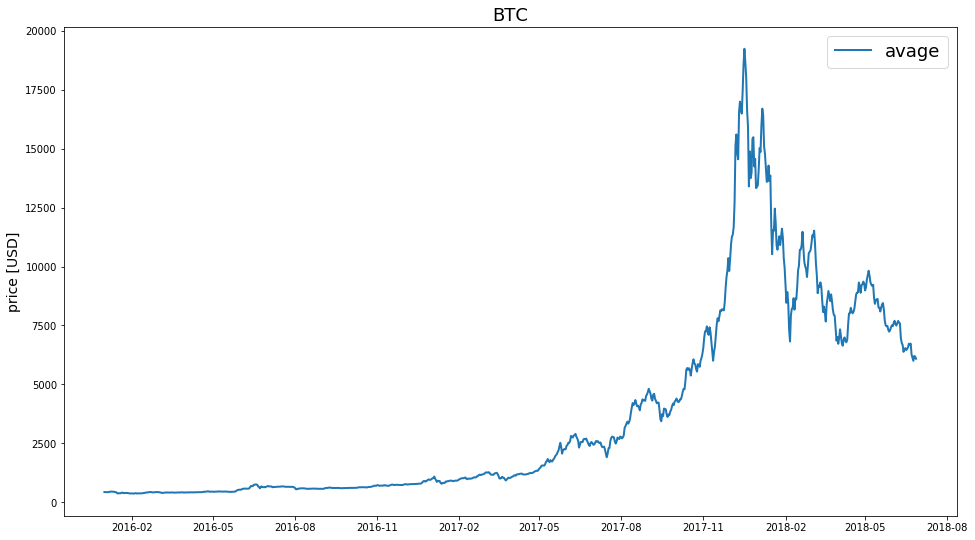

In [15]:
line_plot_s(btc_usd_datasets.average, 'avage', 'BTC')

 ## 並從 poloniex 下載其它虛擬貨幣資料拉入當欄位
 ### 這邊選擇除了BTC以外幾個比較知名的虛擬貨幣
 ### 包含了乙太坊、萊特幣、瑞波幣、門羅幣等
 ### 這4種分別都有各自知名的成因與背後支持的技術
 #### 但因為前面有提到法幣出入金的限制
 #### 所以這邊報價選擇USDT，USDT是一款"號稱"與美金1:1掛鉤的虛擬貨幣
 #### 雖然實際上USDT的價值可能不一定是1美金，但相差不大，姑且作為美金報價

In [16]:
# 從Poloniex下載交易資料 我們將下載4個虛擬貨幣： Ethereum，Litecoin，Ripple，Monero的交易資料
altcoins = ['ETH','LTC','XRP','XMR']
altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'USDT_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451577600.0&end=1530169947.189271&period=86400 at USDT_ETH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451577600.0&end=1530169948.069596&period=86400 at USDT_LTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451577600.0&end=1530169948.848786&period=86400 at USDT_XRP
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XMR&start=1451577600.0&end=1530169949.472612&period=86400 at USDT_XMR


In [17]:
# merge price dataseries' into a single dataframe
altcoin_usd_datasets = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'weightedAverage')
# Remove "0" values 
altcoin_usd_datasets.replace(0, np.nan, inplace=True)

In [18]:
altcoin_usd_datasets

,ETH,LTC,XRP,XMR
date,,,,
2016-01-01,0.918600,3.563049,0.005999,0.510780
2016-01-02,0.957000,3.568911,0.006127,0.557775
2016-01-03,0.966507,3.435222,0.006149,0.485490
2016-01-04,0.952906,3.435230,0.006149,0.513003
2016-01-05,0.939680,3.550613,0.006149,0.499595
2016-01-06,0.938506,3.455243,0.006104,0.506093
2016-01-07,0.962401,3.492098,0.005969,0.470000
2016-01-08,0.985378,3.570236,0.005886,0.510517
2016-01-09,0.995999,3.585341,0.006137,0.470000


## 資料整合：加入其它貨幣合併
#### 合併上面抓取到的比特幣報價與其他虛擬貨幣的報價，整合為單一的DataFrame做為資料集

In [19]:
hist = pd.merge(btc_usd_datasets,altcoin_usd_datasets, left_index=True, right_index=True)

## 將14天的價格變化資料分為訓練及測試集
#### 利用前面建立的函數快速輕鬆地建立好訓練與測試用的資料集

In [20]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

## 訓練LSTM 模型

In [21]:
model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=4)

Epoch 1/100
805/805 [==============================] - 9s 11ms/step - loss: 0.0671
Epoch 2/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0511
Epoch 3/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0465
Epoch 4/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0445
Epoch 5/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0410
Epoch 6/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0395A: 
Epoch 7/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0384
Epoch 8/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0372
Epoch 9/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0356
Epoch 10/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0353
Epoch 11/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0350
Epoch 12/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0337
Epoch 13/

805/805 [==============================] - 6s 8ms/step - loss: 0.0294A: 0s - loss: 0.
Epoch 99/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0297
Epoch 100/100
805/805 [==============================] - 6s 8ms/step - loss: 0.0289


## 還原結果
#### 因為資料集都是經過normailise的數值
#### 所以這邊需要再把normailise的數值還原成實際的價格

In [22]:
target_col='average'
window=14
targets = test[target_col][window:]
preds = model.predict(X_test).squeeze()
preds = test.average.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

## 繪製30天比較圖

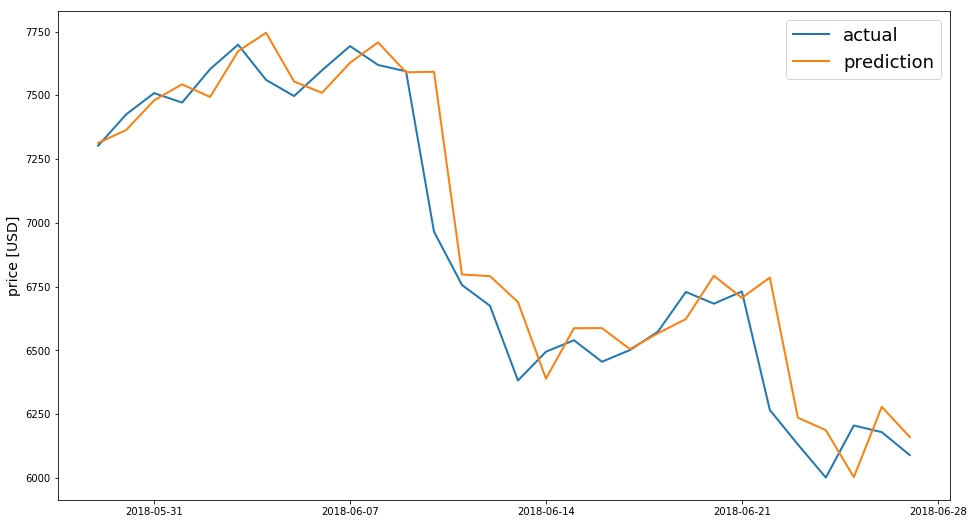

In [23]:
n = 30
line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')